# Physics-Informed Neural Network (PINN) for Gravitational Lensing

 In this notebook, we are making the architecture take the form of a physics informed neural network (PINN). We are using the gravitational lensing equation as specified in the task. We have also added more physics flavor to the notebook.

 We have relied heavily on the related papers provided in the project description, specially
 1. Deep Learning the Morphology of Dark Matter Substructure
 2. LensPINN: Physics Informed Neural Network for Learning Dark Matter Morphology in Lensing

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [2]:
base_dir = r"/mnt/Data/GSoC25/ML4SCI/Evaluation Task/data/dataset/dataset"

### Loading Dataset
same as the baseline

In [3]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.data = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.data.append(os.path.join(cls_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = np.load(img_path).squeeze(0)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        return img, label

### Physics preprocessing

Some physics preprocessing added, inspired by LensPINN paper

In [4]:
def physics_preprocess(images):
    I_max = images.max(dim=2, keepdim=True)[0].max(dim=3, keepdim=True)[0] + 1e-6
    log_term = torch.log(I_max / (images + 1e-6))**2
    grad_x = torch.gradient(log_term, dim=3)[0]
    grad_y = torch.gradient(log_term, dim=2)[0]
    grad_xy = grad_x * grad_y
    return torch.tanh(grad_xy)

### PINN Model

This modified model brings together a Vision Transformer (ViT) and a CNN, while keeping physics in the loop to improve gravitational lensing predictions.

- ViT as a Feature Extractor: Uses DINO ViT-S/16, tweaked to handle single-channel images.
- Physics-Aware Processing: Computes the source position (theta_S) based on deflection angles (alpha) using the lensing equation.
- CNN for Final Prediction: A modified ResNet-18 takes in both the processed input and theta_S to make the final call.
- Dropout for Stability: Uses dropout (0.3 in ViT, 0.5 in CNN) to avoid overfitting.

In [ ]:
class LensVIT_PINN(nn.Module):
    def __init__(self):
        super(LensVIT_PINN, self).__init__()
        self.vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
        orig_proj = self.vit.patch_embed.proj
        new_proj = nn.Conv2d(1, 384, kernel_size=16, stride=16)
        with torch.no_grad():
            new_proj.weight.copy_(orig_proj.weight.mean(dim=1, keepdim=True))
            new_proj.bias.copy_(orig_proj.bias)
        self.vit.patch_embed.proj = new_proj
        self.vit.head = nn.Identity()
        # self.dropout1 = nn.Dropout(0.3)  
        self.alpha_proj = nn.Linear(384, 150*150*2)
        self.cnn = resnet18(pretrained=True)
        self.cnn.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3)
        # self.dropout2 = nn.Dropout(0.5)  
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 3)

    def lensing_equation(self, theta_I, alpha):
        batch_size = theta_I.size(0)
        alpha = alpha.view(batch_size, 150, 150, 2)
        theta = torch.norm(theta_I, dim=1, keepdim=True)
        theta_E = alpha.mean(dim=(2, 3)).mean(dim=1, keepdim=True).view(batch_size, 1, 1, 1)
        alpha_sis = theta_E * theta_I / (theta + 1e-6)
        theta_S = theta_I - alpha_sis
        theta_S = theta_S.clamp(0, 149)
        return theta_S
    
    def forward(self, x):
        x_processed = physics_preprocess(x)
        vit_features = self.vit(x_processed)
        # vit_features = self.dropout1(vit_features)
        alpha = self.alpha_proj(vit_features)
        theta_S = self.lensing_equation(x_processed, alpha)
        combined_input = torch.cat([x_processed, theta_S], dim=1)
        return self.cnn(combined_input)  

### Training Function
Used a physics loss to keep lensing predictions realistic by comparing expected and predicted source positions.

In [9]:
def train_model_with_physicsLoss(model, train_loader, val_loader, epochs=50, device=device):
    criterion = nn.CrossEntropyLoss()
    physics_criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-4)  
    best_auc = 0
    

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            ce_loss = criterion(outputs, labels)
            vit_features = model.vit(images)
            alpha = model.alpha_proj(vit_features)
            theta_S = model.lensing_equation(images, alpha)
            alpha_reshaped = alpha.view(images.size(0), 150, 150, 2).mean(dim=-1).unsqueeze(1)
            physics_loss = physics_criterion(theta_S, images - alpha_reshaped)
            loss = ce_loss + 0.01 * physics_loss  
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds)
        val_labels = np.concatenate(val_labels)
        auc_score = roc_auc_score(val_labels, val_preds, multi_class='ovr')
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, AUC: {auc_score:.4f}')

        if auc_score > best_auc:
            best_auc = auc_score
            torch.save(model.state_dict(), 'LensVIT_PINN_weights.pth')

### Evaluation Function

In [11]:
def evaluate_model(model, val_loader, device=device):
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_preds.append(torch.softmax(outputs, dim=1).cpu().numpy())
            test_labels.append(labels.cpu().numpy())

    test_preds = np.concatenate(test_preds)
    test_labels = np.concatenate(test_labels)

    fpr, tpr, roc_auc = {}, {}, {}
    class_names = ['No Substructure', 'Subhalo', 'Vortex']
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(test_labels == i, test_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LensVIT_PINN')
    plt.legend()
    plt.show()

    print("AUC Scores:", roc_auc)

### Setting up and Running

Using cache found in /home/eman/.cache/torch/hub/facebookresearch_dino_main
/home/eman/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eman/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Firing up LensPINN training...
Epoch 1, Loss: 1.1197, AUC: 0.5267
Epoch 2, Loss: 1.1015, AUC: 0.5486
Epoch 3, Loss: 1.0863, AUC: 0.5813
Epoch 4, Loss: 1.0593, AUC: 0.6523
Epoch 5, Loss: 1.0138, AUC: 0.6915
Epoch 6, Loss: 0.9738, AUC: 0.7372
Epoch 7, Loss: 0.9356, AUC: 0.7625
Epoch 8, Loss: 0.9024, AUC: 0.7679
Epoch 9, Loss: 0.8655, AUC: 0.7564
Epoch 10, Loss: 0.8323, AUC: 0.7941
Epoch 11, Loss: 0.8028, AUC: 0.7896
Epoch 12, Loss: 0.7788, AUC: 0.8106
Epoch 13, Loss: 0.7579, AUC: 0.8320
Epoch 14, Loss: 0.7315, AUC: 0.8295
Epoch 15, Loss: 0.7113, AUC: 0.8351
Epoch 16, Loss: 0.6962, AUC: 0.8378
Epoch 17, Loss: 0.6783, AUC: 0.8491
Epoch 18, Loss: 0.6588, AUC: 0.8567
Epoch 19, Loss: 0.6399, AUC: 0.8523
Epoch 20, Loss: 0.6222, AUC: 0.8502
Epoch 21, Loss: 0.6043, AUC: 0.8613
Epoch 22, Loss: 0.5949, AUC: 0.8501
Epoch 23, Loss: 0.5695, AUC: 0.8733
Epoch 24, Loss: 0.5533, AUC: 0.8658
Epoch 25, Loss: 0.5408, AUC: 0.8619
Epoch 26, Loss: 0.5308, AUC: 0.8542
Epoch 27, Loss: 0.5140, AUC: 0.8707
Epoch 

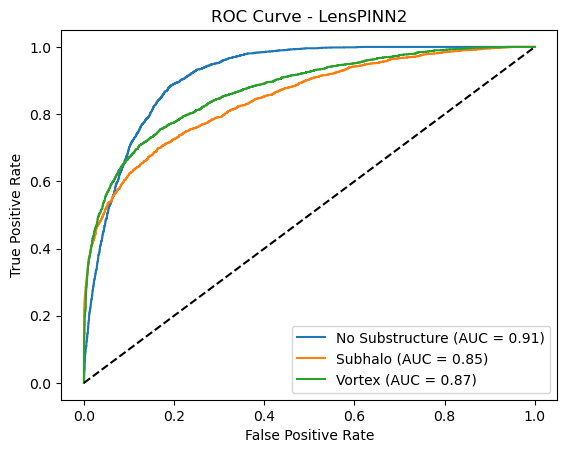

AUC Scores: {0: 0.91458448, 1: 0.847772, 2: 0.8733799200000001}


In [8]:
transform = transforms.Compose([transforms.RandomRotation(10)]) 

train_dataset = LensingDataset(base_dir, split='train', transform=transform)
val_dataset = LensingDataset(base_dir, split='val')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

torch.cuda.empty_cache()
pinn = LensVIT_PINN().to(device)
print("Firing up LensPINN training...")
train_model_with_physicsLoss(pinn, train_loader, val_loader, epochs=50)
pinn.load_state_dict(torch.load('LensVIT_PINN_weights.pth'))
evaluate_model(pinn, val_loader)